# **EMOTION CLASSIFICATION**

Lorenzo Conte - 5206353 \
Alessia Guarneri - 5205957 \
Riccardo Mira - 5205744

The dataset we use in our project consists of 31,807 images of faces of individuals with dimensions 48 x 48 pixels. \
Facial expression has allowed us to categorize the images into 6 categories: Angry, Fear, Happy, Neutral, Sad, Surprise.

Source: https://www.kaggle.com/datasets/juniorbueno/rating-opencv-emotion-images

**Aim**: The aim of this project is to classify each image into its respective class.

## Import libraries and install d2l package

In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import os
d2l.use_svg_display()
%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imposto directory
%cd /content/drive/MyDrive/Progetto

/content/drive/MyDrive/Progetto


In [ ]:
# tolgo la zip
!unzip archive.zip

## EXPLANATORY ANALYSIS

In [ ]:
# dashboard

directory_path= "/content/drive/MyDrive/Progetto/Images/train"
val_directory_path = "/content/drive/MyDrive/Progetto/Images/validation"

The dataset we use in our project consists of 31,807 images of faces of individuals with dimensions (48 x 48). \
Facial expression has allowed us to categorize the images into 6 categories: Angry, Fear, Happy, Neutral, Sad, Surprise.

In [ ]:
new_folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

# classes
sorted_folders = sorted(new_folders)
print(sorted_folders)

# number of classes
num_classes = len(sorted_folders)
print(num_classes)

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
6


In [ ]:
# Number of image per folder

label_name = []
num_image_folder = []

for j in sorted_folders:
    cartella = os.path.join(directory_path, j)
    if os.path.isdir(cartella):
        label_name.append(j)
        num_file = len(os.listdir(cartella))
        num_image_folder.append(num_file)
        print(f'Cartella: {cartella}, Numero di file: {num_file}')

Cartella: /content/drive/MyDrive/Progetto/Images/train/Angry, Numero di file: 3995
Cartella: /content/drive/MyDrive/Progetto/Images/train/Fear, Numero di file: 4097
Cartella: /content/drive/MyDrive/Progetto/Images/train/Happy, Numero di file: 7215
Cartella: /content/drive/MyDrive/Progetto/Images/train/Neutral, Numero di file: 4965
Cartella: /content/drive/MyDrive/Progetto/Images/train/Sad, Numero di file: 4830
Cartella: /content/drive/MyDrive/Progetto/Images/train/Surprise, Numero di file: 3171


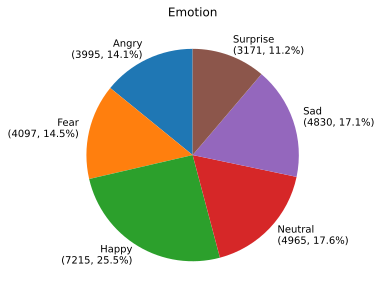

In [ ]:
# percentages
percentages = [num / sum(num_image_folder) * 100 for num in num_image_folder]

# pie chart
plt.pie(num_image_folder, labels=[f'{label}\n({num}, {percentage:.1f}%)' for label, num, percentage in zip(label_name, num_image_folder, percentages)], startangle=90)
plt.title('Emotion')
plt.show()

As visible from the graph, the classes are quite balanced. \
Each class represents a percentage of the total that ranges between approximately 14% and 17%, with the exception of the "Happy" class, which is the largest class, representing about 25% of the total and the "Surprise" class, which represents only 11%

## Dataset



In [ ]:
# trasformations
data_augmentation = transforms.Compose([
        transforms.Resize((224,224)),    # 224 x 224
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),

    ])

data_augmentation1 = trasforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])


With the data augmentation function, we applied various transformations to the images to generate training examples with realistic variations of the original images. These transformations aim to prevent overfitting issues and assist the model in learning more robust features. \
The function involves upsampling the image (from 48x48 to 124x124), converting them to grayscale, applying random horizontal flipping, converting them to PyTorch tensors, and finally normalizing the images using a mean of [0.485] and a standard deviation of [0.229].

In [ ]:
# image folder
train_set = datasets.ImageFolder(root=directory_path,
                                           transform=data_augmentation)
test_set = datasets.ImageFolder(root=val_directory_path,
                                           transform=data_augmentation1)

In [ ]:
# data loader
batch_size = 256

train_iter = data.DataLoader(train_set,batch_size=batch_size, shuffle=True,
                                             num_workers=4)
test_iter = data.DataLoader(test_set,batch_size=batch_size, shuffle=False,
                                             num_workers=4)


In [ ]:
len(train_set), len(test_set)


(28273, 3534)

In [ ]:
data_iter = iter(train_iter)

In [ ]:
X, y = next(data_iter)  # one minibatch
print(train_set[0][0].shape)
print(X.shape)
print(X[0].shape)
print(y.shape)
print(y[0])
print(torch.is_tensor(X[0]))

torch.Size([1, 224, 224])
torch.Size([256, 1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([256])
tensor(3)
True


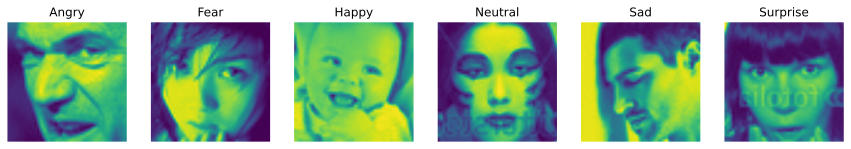

In [ ]:
class_labels = train_set.classes
displayed_classes = []

fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i, (image, label) in enumerate(zip(X, y)):
    label_index = label.item()
    class_label = class_labels[label_index]

    if class_label not in displayed_classes:
        # Permutation of dimensions to fit with matplotlib
        image = image.permute(1, 2, 0)

        # axis index
        class_index = class_labels.index(class_label)

        axes[class_index].imshow(image)
        axes[class_index].set_title(f"{class_label}")
        axes[class_index].axis('off')

        displayed_classes.append(class_label)

    if len(displayed_classes) == num_classes:
        break

plt.show()


# Model

## Model 1
As a first attempt, we decided to try with the traditional **AlexNet** model. \
The model consists of 5 convolutional layers, where the first, second, and fifth are followed by max pooling, and three fully connected layers. \
Dropout is also incorporated.  \
The activation function used is ReLU.

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 6))

In [ ]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

In [ ]:
# function to evaluate the accurancy

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device

    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# Train
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):

    # initialization weights
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')


loss 1.121, train acc 0.571, test acc 0.493
1315.0 examples/sec on cuda:0


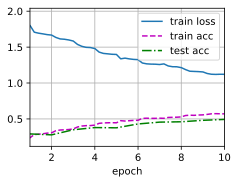

In [ ]:
lr, num_epochs = 0.1, 10
train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

The results obtained are not optimal. In fact, the loss function reaches a value higher than 1, while the training accuracy values do not even reach 60%, and the test accuracy values do not even reach 50%. \
Furthermore, we hypothesize the presence of overfitting despite the inclusion of dropout.

## Model 2

We have decided to make some modifications to the model in an attempt to improve performance. \
We added batch normalization layers after the first and second convolutional layers to normalize data and accelerate the convergence of the deep neural network (batch normalization was added before the activation function). \  
Additionally, we reduced the batch size from 256 to 128 and increased the number of epochs. \
We also chose to apply a regularization technique, namely weight decay with a coefficient of 0.02



In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.BatchNorm2d(96),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.BatchNorm2d(256),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 6))



In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)

    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=0.002)   # weight decay
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):

        metric = d2l.Accumulator(3)
        net.train()

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')


loss 0.993, train acc 0.623, test acc 0.530


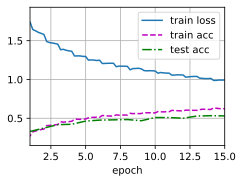

In [ ]:
lr, num_epochs = 0.01, 15
train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

With the changes made, our results have slightly improved, as the loss function has reached a value below 1, and both accuracy values have improved (and the two values are closer).

In [ ]:
# save the model
torch.save(net, 'MM_model.pt')

## Model 3  

We made another attempt; this time, we added a convolutional layer to make our model deeper.

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.BatchNorm2d(96),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.BatchNorm2d(256),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),  # Additional Convolutional Layer
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(3200, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 6)
)


loss 0.906, train acc 0.654, test acc 0.487
1157.0 examples/sec on cuda:0


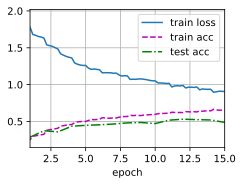

In [ ]:
batch_size=128
lr, num_epochs = 0.1, 15
train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

We observed an improvement in terms of the loss function, which is now less than 1, but still relatively high. Additionally, we noticed an enhancement in train accuracy, albeit at the expense of an increased gap with the test accuracy

## Model 4

In this further attempt, we made additional changes. We decided to modify the activation function, replacing ReLU with LeakyReLU.\
 Furthermore, we reduced the batch size even further, from 128 to 100.\
  The learning rate has been adjusted; in this attempt, it is 0.05.\
   In comparison to previous trials, we eliminated weight decay

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.LeakyReLU(),
    nn.BatchNorm2d(96),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.LeakyReLU(),
    nn.BatchNorm2d(256),   # Batch Normalization
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.LeakyReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.LeakyReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.LeakyReLU(),
    nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.LeakyReLU(),  # Additional Convolutional Layer
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(3200, 4096), nn.LeakyReLU(),  # Adjusted input size based on the added layer
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.LeakyReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(4096, 6)
)


loss 0.905, train acc 0.657, test acc 0.524
1188.8 examples/sec on cuda:0


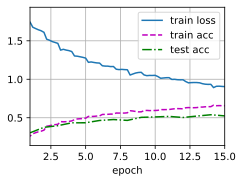

In [ ]:
batch_size= 100
lr, num_epochs = 0.05, 15
train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

In this attempt as well, the loss function takes a significantly improved value compared to the initial models and is in line with the previous model.\
 The value of train accuracy is almost identical to the previous model, while the gap between train and test accuracy slightly decreases. However, with a difference greater than 10%, it still leads us to hypothesize the presence of overfitting.

# Model chosen

In the model selection process, we made several attempts. In this file, we have included only the 4 models that returned the best performance indices, even though the values do not indicate perfect models.\
 All the models listed in this file took AlexNet as a starting point, but we explored other well-known models in our attempts that did not prove to be suitable.

 Among the 4 models reported, we ultimately chose **Model 2**.\
  Despite the loss function value not being particularly optimal, it was the model with the smallest gap between train accuracy and test accuracy. This led us to hypothesize that this model had the least overfitting issue.

# Prediction

In [ ]:
# load model
Model = torch.load('MM_model.pt')

In [ ]:
# make prediction
for x, y in test_iter:
  break
x , y = x.cuda(), y.cuda()
pred = torch.exp(Model(x)).argmax(axis=1)

In [ ]:
#  real values
print(y)

tensor([1, 3, 1, 1, 2, 0, 2, 4, 3, 1, 2, 3, 4, 2, 1, 2, 2, 2, 1, 2, 1, 5, 0, 0,
        3, 0, 2, 1, 3, 0, 1, 2, 1, 3, 0, 2, 0, 1, 0, 2, 2, 4, 4, 4, 2, 0, 0, 3,
        2, 0, 2, 4, 2, 4, 2, 2, 1, 0, 4, 3, 3, 4, 2, 3, 3, 4, 4, 2, 2, 5, 1, 4,
        3, 4, 1, 5, 5, 3, 1, 3, 5, 4, 3, 5, 5, 3, 4, 1, 5, 2, 5, 0, 0, 5, 2, 2,
        4, 4, 2, 1, 1, 3, 5, 4, 3, 5, 2, 2, 4, 0, 0, 2, 1, 4, 2, 0, 3, 1, 1, 0,
        0, 3, 0, 1, 1, 4, 3, 2], device='cuda:0')


In [ ]:
print(pred)

tensor([2, 0, 1, 4, 2, 0, 2, 4, 2, 2, 2, 2, 4, 2, 5, 2, 2, 2, 0, 2, 4, 3, 0, 0,
        2, 0, 2, 3, 2, 0, 1, 0, 4, 5, 3, 2, 0, 0, 0, 2, 2, 3, 4, 1, 2, 1, 1, 5,
        2, 0, 2, 3, 3, 4, 3, 2, 0, 3, 0, 4, 5, 4, 2, 2, 4, 4, 5, 2, 2, 5, 4, 4,
        0, 3, 5, 1, 5, 0, 4, 2, 5, 4, 3, 5, 5, 1, 4, 1, 5, 2, 5, 3, 4, 5, 2, 4,
        4, 4, 2, 0, 1, 1, 5, 5, 4, 5, 2, 2, 4, 4, 3, 2, 1, 4, 2, 0, 2, 3, 3, 4,
        1, 5, 4, 0, 0, 4, 5, 2], device='cuda:0')


We have decided to display the first 10 images from the batch, highlighting both the true class and the one predicted by the model

In [ ]:
print(pred[:10])
print(y[:10])

tensor([2, 0, 1, 4, 2, 0, 2, 4, 2, 2], device='cuda:0')
tensor([1, 3, 1, 1, 2, 0, 2, 4, 3, 1], device='cuda:0')


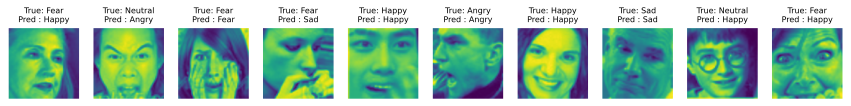

In [ ]:
# It's a list with all the name of the classes
class_names = sorted_folders

# plot
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i in range(10):
    image_array = np.asarray(x[i][0].cpu())
    axes[i].imshow(image_array)
    axes[i].axis('off')
    true_label = class_names[y[i]]
    pred_label = class_names[pred[i]]
    axes[i].set_title(f"True: {true_label}\nPred : {pred_label}", fontsize=8)


plt.show()

# Conclusion

Our initial goal was to classify images into their respective emotional classes.

 In order to achieve this, we experimented with various well-known models (GoogLeNET, ResNet, and AlexNet), and the most performant proved to be AlexNet.

 AlexNet was used as a starting point for the creation of our final model. Our model provided a test accuracy value of **0.53**. We expected higher values, as we were aware that other projects with the same objective have achieved slightly higher accuracy results (around 0.7). According to our judgment, the reasons for these results were as follows:

*   The images were of a reduced size (48x48).
*   The images were initially black and white, providing less information.
* The images were of poor quality; some had overlaid text on faces, while others (although few) only had text. \

In general, we consider ourselves quite satisfied with the final results, as our model doesn't exhibit significant overfitting issues, and the accuracy is still reasonably in line with other projects.



